# Clasificador binario con RandomForest del tipo de violencia "atención no autorizada".

Se tienen dos tipos "no tuvo violencia" y "abuso y violencia. Este último incluye a los de la categoría "ambos".

Sin preprocesamiento en el dataset. Todas las columnas se tratan como continuas aunque sean categóricas.

https://www.cienciadedatos.net/documentos/py08_random_forest_python.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=forest#sklearn.ensemble.RandomForestClassifier

In [1]:
# Custom functions
# ==============================================================================
from funciones import CargarPandasDatasetCategoricos, BorrarColumnas, InsertarColumnaNueva

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import time

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import ParameterGrid, KFold
from chefboost import Chefboost as chef
from sklearn.model_selection import train_test_split

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
def escalar(df, scal):
    ind = df.index
    retail_scaler = pd.DataFrame(scal.fit_transform(df), index=ind)
    retail_scaler.columns = df.columns
    return retail_scaler, scal

In [4]:
def grid(param_grid, X, y, cv=5):
    resultados = {'params': [], 'f1': [], 'cm': []}
    importances = []
    kf = KFold(n_splits=cv, shuffle=True)
    
    for i,params in enumerate(param_grid):
        f1 = []
        cm = []

        for train_index, test_index in kf.split(X):

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            modelo = RandomForestClassifier(
                        n_jobs       = -1,
                        ** params
                     )

            modelo.fit(X_train, y_train)

            y_pred = modelo.predict(X_test)
            
            importances.append(modelo.feature_importances_)
            
            f1.append(f1_score(y_test, y_pred))
            cm.append(confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel())
            
        resultados['params'].append(params)
        resultados['f1'].append(max(f1))
        resultados['cm'].append(cm[f1.index(max(f1))])
        
        if i%300 == 0 or i==len(param_grid):
            print(f"Modelo {i}, f1({max(f1)}): {params} \u2713")
    
    #hacer dataset con resultados
    resultados = pd.DataFrame(resultados)
    resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
    resultados = resultados.drop(columns = 'params')
    
    return resultados, importances

## Cargar datos

In [5]:
endireh = CargarPandasDatasetCategoricos('datasets/endireh.csv')

## Preprocesamiento


Solo nos quedamos con las que sufieron 'atención no autorizada'.

Eliminando los de Abuso y violencia

In [6]:
endireh.drop(endireh[endireh["P9_8"]==1].index, axis=0, inplace=True)

'atencion no autorizada' y 'ambos' sean 1.

In [7]:
endireh.loc[endireh["P9_8"]>0, "P9_8"] = 1

In [8]:
endireh.shape

(15647, 49)

Ninguno(0):	80%
Abuso y violencia(1):	20%


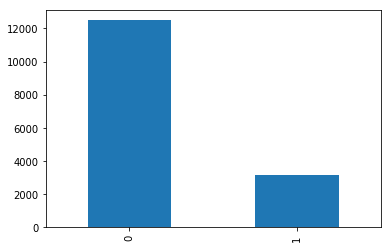

In [9]:
for i,j in zip(['Ninguno(0)', 'Abuso y violencia(1)'], endireh["P9_8"].value_counts()/endireh["P9_8"].value_counts().sum()):
    print(f'{i}:\t{round(j*100)}%')
endireh["P9_8"].value_counts().plot(kind='bar')

Al ser el análisis nacional borramos la variable _REGION_ que no pertenece a este estudio en particular y Elimino _y_ del dataset.

In [10]:
endireh.drop(columns=['REGION'], inplace=True)
#endireh.drop(columns=['P9_8', 'REGION'], inplace=True)
#X_train, X_test, y_train, y_test = train_test_split(endireh, y, test_size=0.33, random_state=5)

Obtengo la variable objetivo y obtengo el dataset X borrando P9_8.

In [11]:
y = endireh['P9_8'].copy()

In [12]:
X = endireh.drop(columns=['P9_8'], inplace=False)

In [20]:
endireh.loc[endireh["P9_8"]==0, "P9_8"] = 'No'
endireh.loc[endireh["P9_8"]==1, "P9_8"] = 'Si'

In [21]:
X_train, X_test = train_test_split(endireh, test_size=0.2, random_state=5, stratify=endireh['P9_8'])

## Encontrar los mejores parámetros con _Random Forest_

In [13]:
param_grid = ParameterGrid(
                {
                 'max_features'      : ['auto', 'sqrt', 'log2'],
                 'criterion'         : ['gini', 'entropy'],
                 'warm_start'        : [True, False],
                 'bootstrap'         : [True, False],
                 'min_samples_split' : range(285, 580, 25),
                 'min_samples_leaf'  : range(150, 200, 2),
                 'random_state'      : [5],
                }
            )


In [14]:
print("Current Time is :", time.strftime("%H:%M:%S", time.localtime()))

Current Time is : 08:40:15


In [15]:
%time resultados, importances = grid(param_grid, X, y)

Modelo 0, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 150, 'min_samples_split': 285, 'random_state': 5, 'warm_start': True} ✓
Modelo 300, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 174, 'min_samples_split': 435, 'random_state': 5, 'warm_start': True} ✓
Modelo 600, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 150, 'min_samples_split': 285, 'random_state': 5, 'warm_start': True} ✓
Modelo 900, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 174, 'min_samples_split': 435, 'random_state': 5, 'warm_start': True} ✓
Modelo 1200, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 150, 'min_samples_split': 285, 'random_state': 5, 'warm_start': True} ✓
Modelo 1500, f1(0.0): {'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 174,

In [16]:
print("Current Time is :", time.strftime("%H:%M:%S", time.localtime()))

Current Time is : 14:16:32


In [17]:
resultados.sort_values(by=['f1'], ascending=False).head(5)

,f1,cm,bootstrap,criterion,max_features,min_samples_leaf,min_samples_split,random_state,warm_start
0,0.0,"[2529, 0, 601, 0]",True,gini,auto,150,285,5,True
4837,0.0,"[2490, 0, 640, 0]",False,gini,log2,152,435,5,False
4807,0.0,"[2514, 0, 616, 0]",False,gini,log2,150,360,5,False
4806,0.0,"[2497, 0, 633, 0]",False,gini,log2,150,360,5,True
4805,0.0,"[2508, 0, 622, 0]",False,gini,log2,150,335,5,False


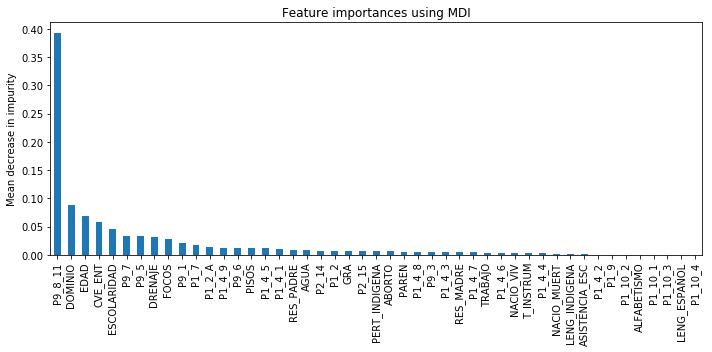

In [18]:
forest_importances = pd.Series(np.mean(importances, axis = 0), index=X.columns)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
#forest_importances[:15].plot.bar(yerr=std, ax=ax)
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Encontrar los mejores parámetros con _Chefboost_

https://towardsdatascience.com/chefboost-an-alternative-python-library-for-tree-based-models-f46af028a348

https://github.com/serengil/chefboost

https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/

https://sefiks.com/2019/08/31/a-begineers-guide-to-decision-trees-in-python/


### ID3

In [50]:
config = {'algorithm':'ID3', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
ID3  tree is going to be built...
-------------------------
finished in  1184.7854826450348  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  12517  instances
Labels:  ['No' 'Si']
Confusion matrix:  [[9991, 0], [0, 2526]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 19min 41s, sys: 4.2 s, total: 19min 45s
Wall time: 19min 45s


In [51]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  69.61661341853035 % on  3130  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[180, 499], [452, 1999]]
Precision:  26.5096 %, Recall:  28.481 %, F1:  27.46 %


### C4.5

In [52]:
config = {'algorithm':'C4.5', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  1192.500914812088  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  12517  instances
Labels:  ['No' 'Si']
Confusion matrix:  [[9991, 0], [0, 2526]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 19min 48s, sys: 5.25 s, total: 19min 53s
Wall time: 19min 53s


In [53]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  67.60383386581469 % on  3130  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[185, 567], [447, 1931]]
Precision:  24.6011 %, Recall:  29.2722 %, F1:  26.7341 %


### CHAID

In [54]:
config = {'algorithm':'CHAID', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...
-------------------------
finished in  1848.9130702018738  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  12517  instances
Labels:  ['No' 'Si']
Confusion matrix:  [[9991, 0], [0, 2526]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 30min 43s, sys: 5.29 s, total: 30min 49s
Wall time: 30min 49s


In [55]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  68.01916932907348 % on  3130  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[157, 526], [475, 1972]]
Precision:  22.9868 %, Recall:  24.8418 %, F1:  23.8783 %


### enableGBM

In [56]:
config = {'enableGBM': True, 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

Boosting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO]:  -1 CPU cores will be allocated in parallel running
Gradient Boosting Machines...
Regression  tree is going to be built...
gradient boosting for classification


Epoch 10. Accuracy: 96. Process: : 100%|██████████| 10/10 [4:27:24<00:00, 1604.47s/it]


The best accuracy got in  4  epoch with the score  96.34896540704642
-------------------------
finished in  16044.740900754929  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  0.0 % on  12517  instances
Labels:  ['No' 'Si']
Confusion matrix:  [[0, 0], [0, 0]]
Precision:  0.0 %, Recall:  0.0 %, F1:  0.0 %


CPU times: user 4h 26min 21s, sys: 1min, total: 4h 27min 21s
Wall time: 4h 27min 25s


In [57]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  0.0 % on  3130  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[0, 0], [0, 0]]
Precision:  0.0 %, Recall:  0.0 %, F1:  0.0 %


### enableRandomForest 100

In [58]:
config = {'enableRandomForest':True, 'num_of_trees':100, 'algorithm':'CART', 'enableParallelism':True, 'num_cores': 8, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

Sub decision tree 100 is processing: 100%|██████████| 100/100 [00:00<00:00, 744.33it/s]

[INFO]:  8 CPU cores will be allocated in parallel running
CART  tree is going to be built...



100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


-------------------------
finished in  86.28024935722351  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  79.8194455540465 % on  12517  instances
Labels:  ['No' 'Si']
Confusion matrix:  [[9991, 2526], [0, 0]]
Precision:  79.8194 %, Recall:  100.0 %, F1:  88.7773 %


CPU times: user 3.75 s, sys: 125 ms, total: 3.88 s
Wall time: 1min 29s


In [59]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  79.80830670926518 % on  3130  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[0, 0], [632, 2498]]
Precision:  0.0 %, Recall:  0.0 %, F1:  0.0 %


### enableRandomForest 5

In [60]:
config = {'enableRandomForest':True, 'num_of_trees':5, 'algorithm':'CART', 'enableParallelism':True, 'num_cores': 8, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

Sub decision tree 5 is processing: 100%|██████████| 5/5 [00:00<00:00, 247.83it/s]

[INFO]:  8 CPU cores will be allocated in parallel running
CART  tree is going to be built...



100%|██████████| 5/5 [02:03<00:00, 24.72s/it] 


-------------------------
finished in  123.83575439453125  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.7847727091156 % on  12517  instances
Labels:  ['No' 'Si']
Confusion matrix:  [[9413, 1702], [578, 824]]
Precision:  84.6874 %, Recall:  94.2148 %, F1:  89.1974 %


CPU times: user 1.94 s, sys: 97 ms, total: 2.04 s
Wall time: 2min 5s


In [61]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  74.88817891373802 % on  3130  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[93, 247], [539, 2251]]
Precision:  27.3529 %, Recall:  14.7152 %, F1:  19.1358 %


### CART

In [62]:
config = {'algorithm':'CART', 'enableParallelism':True, 'num_cores': -1, 'max_depth': 6}
%time model = chef.fit(X_train, config = config, target_label = 'P9_8');print('\n')

[INFO]:  -1 CPU cores will be allocated in parallel running
CART  tree is going to be built...
-------------------------
finished in  1029.383224248886  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  100.0 % on  12517  instances
Labels:  ['No' 'Si']
Confusion matrix:  [[9991, 0], [0, 2526]]
Precision:  100.0 %, Recall:  100.0 %, F1:  100.0 %


CPU times: user 17min 5s, sys: 4.23 s, total: 17min 10s
Wall time: 17min 10s


In [63]:
chef.evaluate(model, X_test, target_label='P9_8', task="test")

-------------------------
Evaluate  test set
-------------------------
Accuracy:  68.78594249201278 % on  3130  instances
Labels:  ['Si' 'No']
Confusion matrix:  [[179, 524], [453, 1974]]
Precision:  25.4623 %, Recall:  28.3228 %, F1:  26.8165 %


### Feature importance

Decision rule:  outputs/rules/rules.py


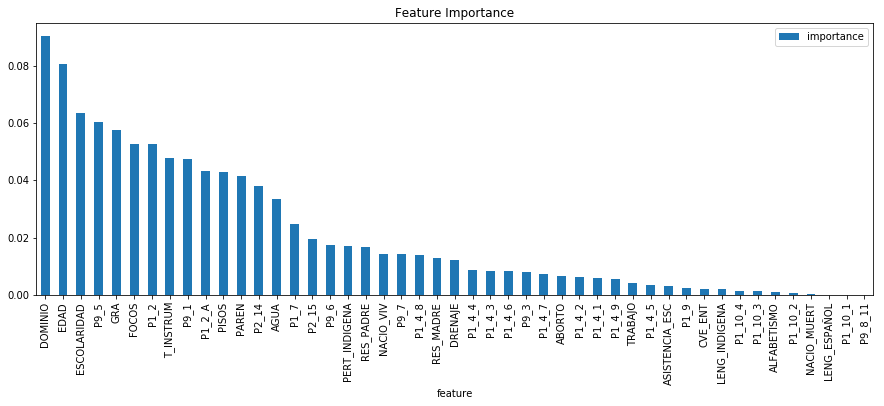

In [64]:
fi = chef.feature_importance("outputs/rules/rules.py")
fi.set_index('feature').plot.bar(title="Feature Importance", figsize=(15,5))

In [66]:
(9*30)+16-263

23